In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_from tensorflow.keras import layers csv)
import os
from PIL import Image, ImageEnhance, ImageChops
import random
from shutil import copyfile
from tensorflow.keras import models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")

2024-04-15 06:17:17.392111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 06:17:17.392261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 06:17:17.520255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_format_counts(path):
    ''' gets the counts of each image format in the specified path'''
    counts = {}

    for image in os.listdir(path):
        img_type = image.split('.')[-1]
        if img_type in counts:
            counts[img_type] += 1
        else:
            counts.update({img_type: 1})
    
    return counts

# Get the counts of formats in the authentic images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'))

# Get the counts of formats in the tampered images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'))

{'jpg': 7437, 'bmp': 54, 'db': 1}
{'jpg': 2064, 'tif': 3059, 'txt': 1, 'db': 1}


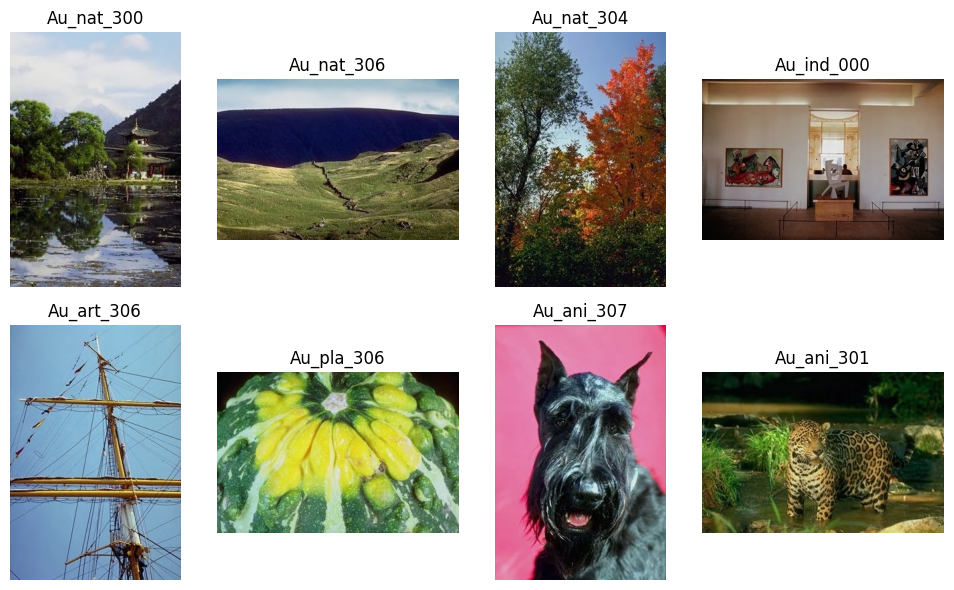

In [3]:
def show_images(path):
    # Get random 8 images from the path
    image_files = random.sample(os.listdir(path), 8)

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 6))

    # Iterate over the image files and plot them in the subplots
    for i, ax in enumerate(axes.flatten()):
        # Load and plot the image
        image_path = os.path.join(path, image_files[i])
        image = plt.imread(image_path)
        ax.imshow(image)
        ax.set_title(image_files[i][:10])  # Set the title as the image filename
        ax.axis('off')  # Turn off axis labels

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

# Path to the authentic images directory
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
show_images(image_dir)

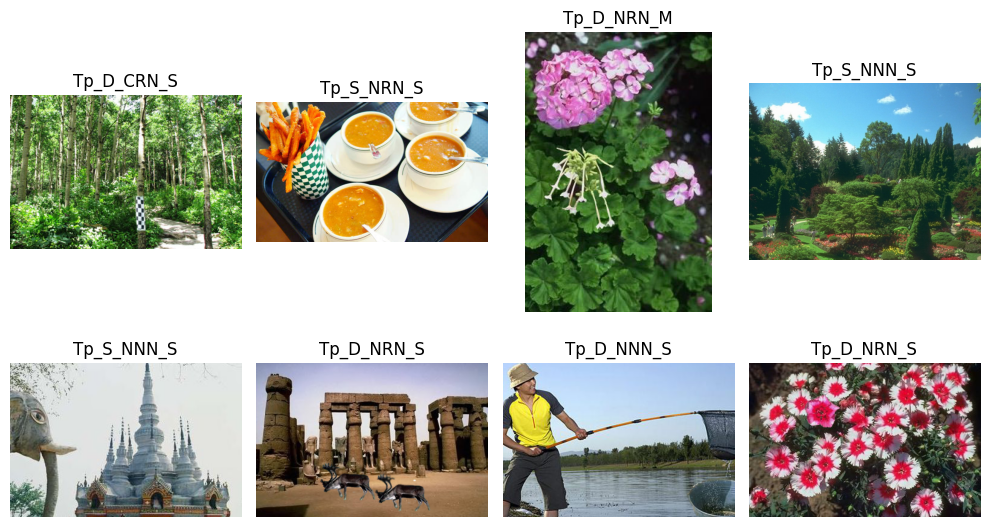

In [4]:
# Path to the tampered images directory
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
show_images(image_dir)

In [5]:
def image_to_ela(path, quality, resave_path):
    ''' Gets images specified as path and resaves it at a new path resave_path at specified quality'''
    try:
        # Check if the file format is supported (JPEG or PNG or TIF)
        if path.endswith('jpg') or path.endswith('jpeg') or path.endswith('png') or path.endswith('tif'):
            # Open the image and convert it to RGB mode
            image = Image.open(path).convert('RGB')
            
            # Resave the image with the specified quality
            image.save('resaved.jpg', 'JPEG', quality=quality)
            resaved = Image.open('resaved.jpg')

            # Calculate the ELA (Error Level Analysis) image by taking the difference between the original and resaved image
            ela_image = ImageChops.difference(image, resaved)

            # Get the minimum and maximum pixel values in the ELA image
            band_values = ela_image.getextrema()
            max_value = max([val[1] for val in band_values])

            # If the maximum value is 0, set it to 1 to avoid division by zero
            if max_value == 0:
                max_value = 1

            # Scale the pixel values of the ELA image to the range [0, 255]
            scale = 255.0 / max_value
            ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

            # Save the ELA image with the same filename in the specified resave path
            ela_image.save(os.path.join(resave_path, os.path.basename(path)), 'JPEG')
    except Exception as e:
        print(f'Could not convert {path} to ELA: {str(e)}')

In [6]:
def preprocess_data(parent_path, files, resave_path):
    ''' Loops through a directory and applies the image_to_ela function to each image in the directory'''
    for file in files:
        image_to_ela(os.path.join(parent_path, file), 90, resave_path)

In [7]:
# get list of all authentic images
auth_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au')

# get list of all Tampered images
doc_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp')

# create the all_reals and all_docs where we save the real and doctored ELA images
os.mkdir('/kaggle/working/all_reals')
os.mkdir('/kaggle/working/all_Doc')

# converting  validation real images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
preprocess_data(parent_path, auth_files, '/kaggle/working/all_reals')

# converting training doctored images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
preprocess_data(parent_path, doc_files, '/kaggle/working/all_Doc')

print('There are ' + str(len(os.listdir('/kaggle/working/all_reals'))) + ' supported Authentic Images')
print('There are ' + str(len(os.listdir('/kaggle/working/all_Doc'))) + ' supported Tampered Images')

There are 7437 supported Authentic Images
There are 5123 supported Tampered Images


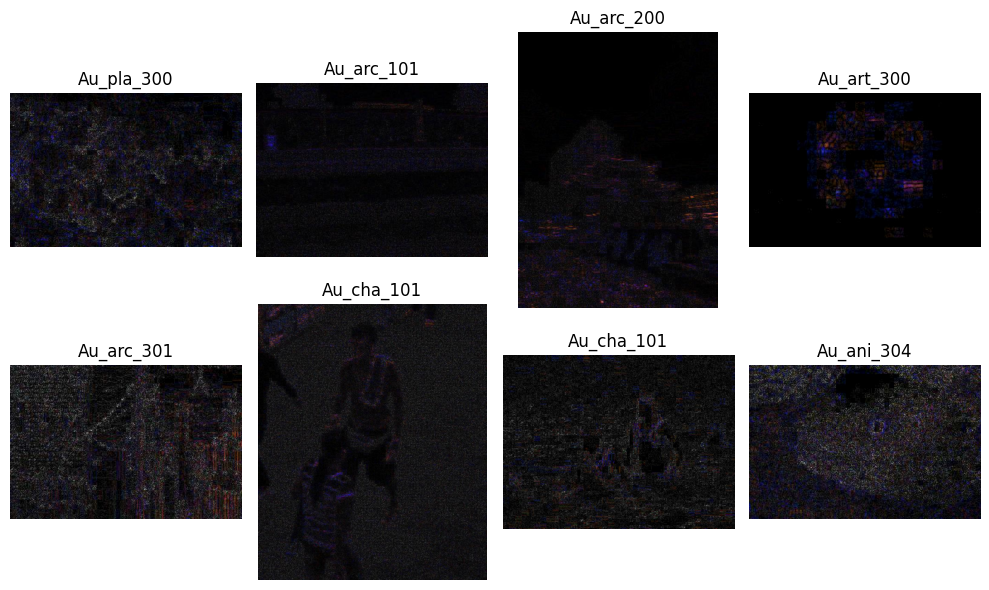

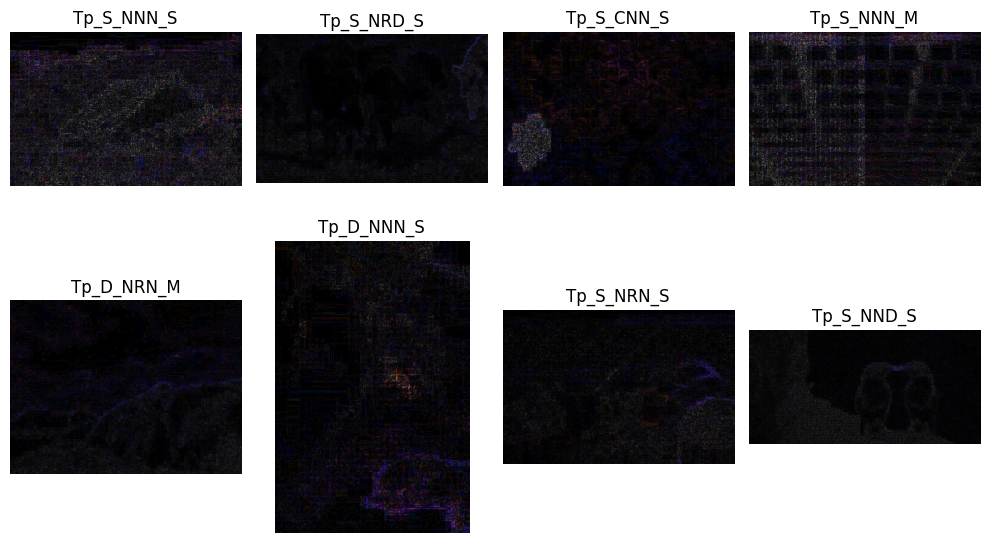

In [8]:
# Path to the authentic ela images directory
image_dir = '/kaggle/working/all_reals'
show_images(image_dir)

# Path to the tampered ela images directory
image_dir = '/kaggle/working/all_Doc'
show_images(image_dir)

In [9]:
# creating the parent directory for both the Training and Validation datasets
ela_path = os.path.join(os.getcwd(), 'ela_images')

# create path for training set and the different labels
auth_path_train = os.path.join(ela_path, 'train',  'Real')
tamp_path_train = os.path.join(ela_path, 'train', 'Doctored')
os.makedirs(auth_path_train)
os.makedirs(tamp_path_train)

# create path for validation set and its different labels
auth_path_val = os.path.join(ela_path, 'Val',  'Real')
tamp_path_val = os.path.join(ela_path, 'Val', 'Doctored')
os.makedirs(auth_path_val)
os.makedirs(tamp_path_val)

In [10]:
# Get the list of files in the 'all_reals' directory
real_files = os.listdir('/kaggle/working/all_reals')

# Get the list of files in the 'all_Doc' directory
doc_files = os.listdir('/kaggle/working/all_Doc')

# Calculate the total length for training and validation sets for doctored images
total_len_train_doc = int((80 / 100) * len(doc_files))
total_len_val_doc = int((20 / 100) * len(doc_files))

# Randomly select files for validation from the authentic image files
val_auth = random.choices(real_files, k=total_len_val_doc)

# Select the remaining files for training from the authentic image files
train_auth = [f for f in real_files if f not in val_auth][:total_len_train_doc]

# Randomly select files for validation from the doctored image files
val_doc = random.choices(doc_files, k=total_len_val_doc)

# Select the remaining files for training from the doctored image files
train_doc = [f for f in doc_files if f not in val_doc][:total_len_train_doc]

# Path to the destination directories for training and validation authentic images
auth_path_train = '/kaggle/working/ela_images/train/Real'
auth_path_val = '/kaggle/working/ela_images/Val/Real'

# Path to the destination directories for training and validation doctored images
tamp_path_train = '/kaggle/working/ela_images/train/Doctored'
tamp_path_val = '/kaggle/working/ela_images/Val/Doctored'

# Copy the training authentic images to ela_images/train/Real
for item in train_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_train, os.path.basename(item)))

# Copy the validation authentic images to ela_images/Val/Real
for item in val_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_val, os.path.basename(item)))

# Copy the training doctored images to ela_images/train/Doctored
for item in train_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(tamp_path_train, os.path.basename(item)))

# Copy the validation doctored images to ela_images/Val/Doctored
for item in val_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(tamp_path_val, os.path.basename(item)))

# Print the lengths of the validation and training sets for authentic and doctored images
print("There are a total of " + str(len(train_auth)) + "Authentic Images in the training set")
print("There are a total of " + str(len(train_doc)) + "Doctored Images in the training set")
print("There are a total of " + str(len(val_auth)) + "Authentic Images in the Validation set")
print("There are a total of " + str(len(val_doc)) + "Doctored Images in the Validation set")

There are a total of 4098Authentic Images in the training set
There are a total of 4098Doctored Images in the training set
There are a total of 1024Authentic Images in the Validation set
There are a total of 1024Doctored Images in the Validation set


In [11]:
# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator()

# Generate training images
train_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)
train_images1 = datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images1 = datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

train_images2= datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images2= datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 8196 images belonging to 2 classes.
Found 1879 images belonging to 2 classes.
Found 8196 images belonging to 2 classes.
Found 1879 images belonging to 2 classes.
Found 8196 images belonging to 2 classes.
Found 1879 images belonging to 2 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16, MobileNetV2
from tensorflow.keras import layers, models

# Step 1: Load pre-trained GoogleNet, VGG and MobileNetV2 models (without top classification layers)
google_net = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the layers of the base models (optional, depends on the dataset size)
for layer in google_net.layers:
    layer.trainable = False
for layer in vgg.layers:
    layer.trainable = False
for layer in mobile_net.layers:
    layer.trainable = False
     
# Step 3: Create fusion model
input_layer = tf.keras.Input(shape=(224, 224, 3))
google_net_features = google_net(input_layer)
vgg_features = vgg(input_layer)
mobile_net_features = mobile_net(input_layer)

# Step 4: Reshape the GoogleNet features to match the shape of VGG features
google_net_features = layers.GlobalAveragePooling2D()(google_net_features)
google_net_features = layers.Dense(1024, activation='relu')(google_net_features)
google_net_features = layers.Reshape((1, 1, 1024))(google_net_features)  # Reshape instead of expand_dims
google_net_features = layers.UpSampling2D(size=(7, 7))(google_net_features)

# Reshape MobileNetV4 Features (if necessary)
if len(mobile_net_features.shape) == 2:
    mobile_net_features = layers.Reshape((1, 1, mobile_net_features.shape[-1]))(mobile_net_v4_features)

# Step 5: Concatenate the feature representations from both models
fusion_features = layers.Concatenate()([google_net_features, vgg_features, mobile_net_features])

# Step 6: Add additional layers for fusion and making predictions
fusion_features = layers.GlobalAveragePooling2D()(fusion_features)
fusion_features = layers.Dense(1024, activation='relu')(fusion_features)
predictions = layers.Dense(1, activation='sigmoid')(fusion_features)

# Step 7: Create the fusion model
model = models.Model(inputs=input_layer, outputs=predictions)

# Step 8: Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now the 'model' is a fusion of GoogleNet and VGG models for your specific task

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
history = model.fit(
    train_images2,  
    steps_per_epoch=int(len(train_images) / 8),
    epochs=100,
    validation_data=validation_images2
)

Epoch 1/100


I0000 00:00:1713162304.002944     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713162304.086460     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5869 - loss: 3.1436

W0000 00:00:1713162321.482348     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5903 - loss: 3.0934 - val_accuracy: 0.8568 - val_loss: 0.3446
Epoch 2/100


W0000 00:00:1713162377.381865     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 611ms/step - accuracy: 0.8725 - loss: 0.3216 - val_accuracy: 0.8850 - val_loss: 0.3003
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 623ms/step - accuracy: 0.8888 - loss: 0.2670 - val_accuracy: 0.8952 - val_loss: 0.2830
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 630ms/step - accuracy: 0.8797 - loss: 0.2945 - val_accuracy: 0.8904 - val_loss: 0.2842
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - accuracy: 0.8904 - loss: 0.2709 - val_accuracy: 0.8946 - val_loss: 0.2707
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - accuracy: 0.8878 - loss: 0.2489 - val_accuracy: 0.8925 - val_loss: 0.2613
Epoch 7/100
20/32 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9190 - loss: 0.2242  

W0000 00:00:1713162500.416437     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9091 - loss: 0.2402 - val_accuracy: 0.8952 - val_loss: 0.2732
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - accuracy: 0.8802 - loss: 0.2986 - val_accuracy: 0.8787 - val_loss: 0.3031
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.9688 - loss: 0.1403 - val_accuracy: 0.8813 - val_loss: 0.3004
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step - accuracy: 0.9145 - loss: 0.2277 - val_accuracy: 0.8946 - val_loss: 0.2645
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - accuracy: 0.8803 - loss: 0.2921 - val_accuracy: 0.8914 - val_loss: 0.2602
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.9235 - loss: 0.1989 - val_accuracy: 0.9010 - val_loss: 0.2546
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - accuracy: 0.8985 - loss: 0.2408 - val_accuracy: 0.8781 - val_loss: 0.2992
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - accuracy: 0.8899 - loss: 0.2754 - val_accura

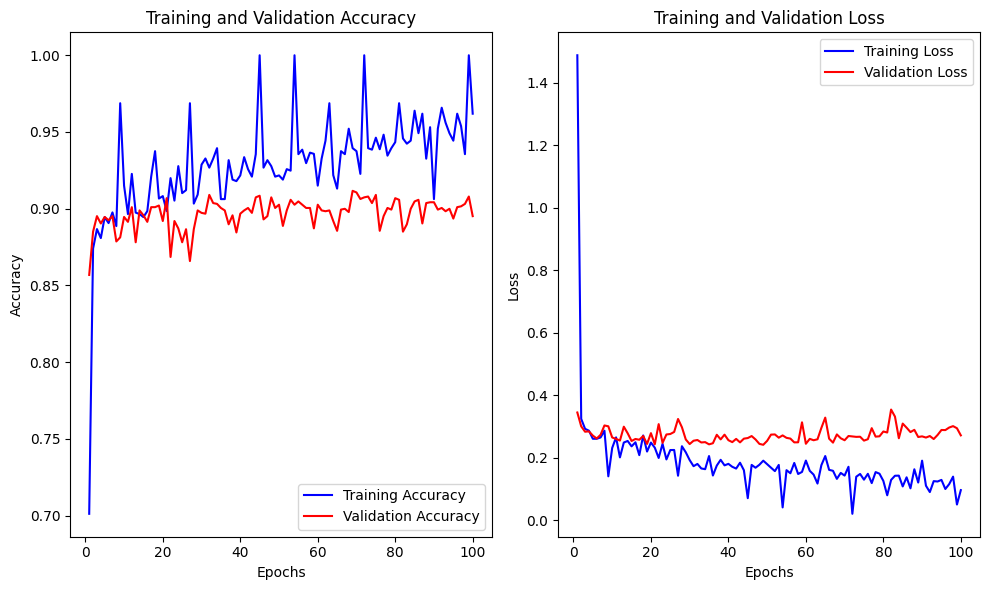

In [14]:
def plot_accuracy(history):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
        
    # Get the training and validation accuracy values from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Get the training and validation loss values from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Get the number of epochs
    epochs = range(1, len(train_acc) + 1)
    
    # Plot the training and validation accuracy
    axes[0].plot(epochs, train_acc, 'b', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    # Plot the training and validation loss
    axes[1].plot(epochs, train_loss, 'b', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    # Adjust the layout
    fig.tight_layout()
    
    # Show the plot
    plt.show()


plot_accuracy(history)

# TESTING

In [15]:
# get list of all authentic images
test_auth_files = os.listdir('/kaggle/input/casia-with-wildlife-and-nature/CASIA2/Au_test')

# get list of all Tampered images
test_doc_files = os.listdir('/kaggle/input/casia-with-wildlife-and-nature/CASIA2/Tp_test')

# create the all_reals and all_docs where we save the real and doctored ELA images
os.makedirs('/kaggle/working/test_real', exist_ok=True)
os.makedirs('/kaggle/working/test_Docs', exist_ok=True)

# converting test real images to ela
parent_path = '//kaggle/input/casia-with-wildlife-and-nature/CASIA2/Au_test'
preprocess_data(parent_path, test_auth_files, '/kaggle/working/test_real')

# converting test doctored images to ela
parent_path = '/kaggle/input/casia-with-wildlife-and-nature/CASIA2/Tp_test'
preprocess_data(parent_path, test_doc_files, '/kaggle/working/test_Docs')

print('There are ' + str(len(os.listdir('/kaggle/working/test_real'))) + ' supported Authentic Images')
print('There are ' + str(len(os.listdir('/kaggle/working/test_Docs'))) + ' supported Tampered Images')


There are 200 supported Authentic Images
There are 200 supported Tampered Images


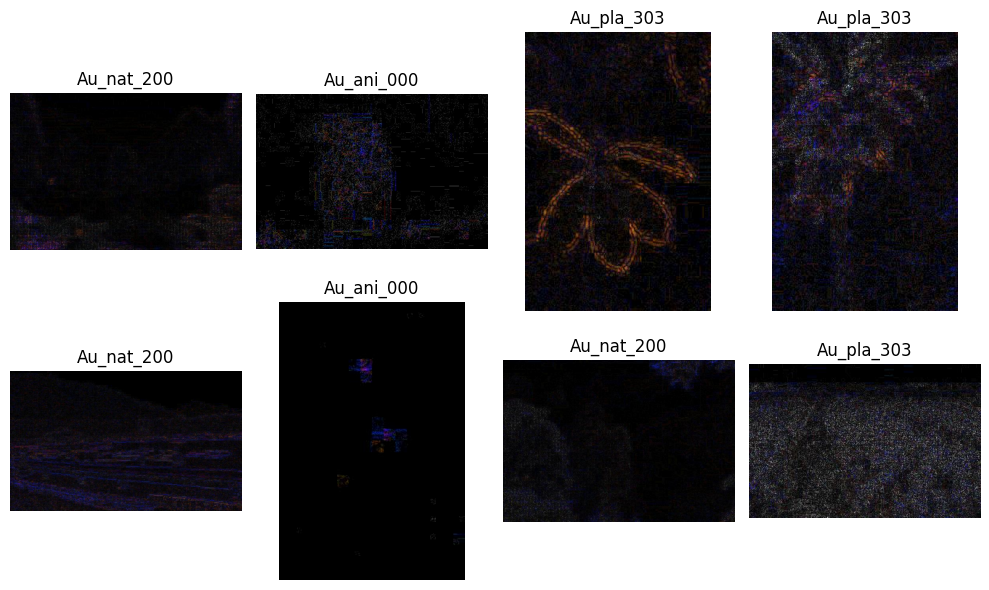

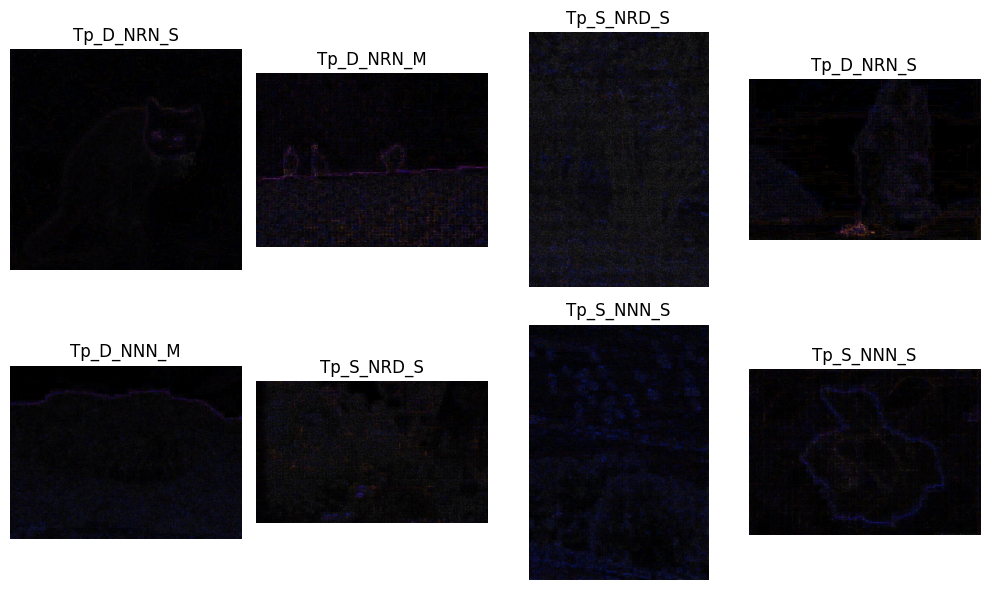

In [16]:
# Path to the authentic ela images directory
image_dir = '/kaggle/working/test_real'
show_images(image_dir)

# Path to the tampered ela images directory
image_dir = '/kaggle/working/test_Docs'
show_images(image_dir)

In [18]:
# creating the parent directory for test dataset
# ela_path = os.path.join(os.getcwd(), 'ela_images')

# create path for test set and the different labels
path_test = os.path.join(ela_path, 'testing')
os.makedirs(path_test, exist_ok=True)

In [19]:
# create path for validation set and its different labels
path_test_au = os.path.join(ela_path, 'testing',  'Real')
path_test_tp = os.path.join(ela_path, 'testing', 'Doctored')

os.makedirs(path_test_au, exist_ok='True')
os.makedirs(path_test_tp, exist_ok='True')

# Get the list of files in the 'test_reals' directory
test_real_files = os.listdir('/kaggle/working/test_real')

# Get the list of files in the 'test_Doc' directory
test_doc_files = os.listdir('/kaggle/working/test_Docs')

# Calculate the total length for test set for doctored images
total_len_test_doc = len(test_doc_files)

# Path to the destination directories for test images
path_test_au = '/kaggle/working/ela_images/testing/Real'
path_test_tp = '/kaggle/working/ela_images/testing/Doctored'

# Copy the test authentic images to ela_images/test
for item in test_real_files:
    copyfile('/kaggle/working/test_real/{}'.format(item), "{}/{}".format(path_test_au, os.path.basename(item)))

# Copy the test doctored images to ela_images/test
for item in test_doc_files:
    copyfile('/kaggle/working/test_Docs/{}'.format(item), "{}/{}".format(path_test_tp, os.path.basename(item)))

# Print the lengths of the test set for authentic and doctored images
print("There are a total of " + str(len(test_real_files)) + " Authentic Images in the test set")
print("There are a total of " + str(len(test_doc_files)) + " Doctored Images in the test set")

There are a total of 200 Authentic Images in the test set
There are a total of 200 Doctored Images in the test set


In [21]:
testing_files = os.listdir('/kaggle/working/ela_images/testing/')

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator for testing data
test_data_generator = ImageDataGenerator()

# Load and preprocess testing data
test_generator = test_data_generator.flow_from_directory(
    '/kaggle/working/ela_images/testing/',
    target_size=(244, 244),
    batch_size=32,
    class_mode='binary',  
    shuffle=True  
)

Found 400 images belonging to 2 classes.


In [23]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

W0000 00:00:1713164391.921433     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713164391.936902     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.8455 - loss: 0.3212
Test Loss: 0.3390895426273346
Test Accuracy: 0.8500000238418579


W0000 00:00:1713164433.085498     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713164433.102458     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
